## Remap from pressure/depth to isopycnals

It is useful to analyze the data on isopycnals for two reasons:
- Remove influence of internal waves
- Tracers are stirred primarily along isopycnals in the interior

Here we will do this remapping using linear interpolation, and start from the data that has already been QCed, overturns removed, and vertically binned.  

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sg
import spectrum 
from scipy import stats, fft
import xarray as xr
from cmocean import cm as cmo

import extra_funcs as ef

In [2]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
# Open data sets that are on z/pressure grid
ds_659_z = xr.open_dataset('../data/sg_659_4m_binned.nc')
ds_660_z = xr.open_dataset('../data/sg_660_4m_binned.nc')

In [4]:
# Calculate a time axis as YTD  
ds_659_z['days'] = ef.datetime2ytd(ds_659_z.time)
ds_660_z['days'] = ef.datetime2ytd(ds_660_z.time)

#### Pressure to density grid
The interpolation requires us to invert functions like 
\begin{equation}
\rho = f(p)
\end{equation}
to 
\begin{equation}
p = g(\rho)
\end{equation}

and also
$$
T = f(p)
$$
to
$$
T = f(g(\rho))
$$

This can be done using interpolation, where we 
- take the variables as a function of pressure and the associated non-uniformly spaced density.
- Find the interpolant function that relates the variable to the non-uniformly spaced density.
- Use this interpolant function to estimate the values at a set of uniformly spaced density points. 

In [5]:
rho_grid = np.linspace(26.8, 27.8,1001)

In [7]:
def interpolate2density(ds_z):
    dive_ind = 0
    pres_tilde_xr = ef.func_var_int(ds_z.isel(dives=dive_ind), 'ctd_pressure',rho_grid)
    CT_tilde_xr   = ef.func_var_int(ds_z.isel(dives=dive_ind), 'CT',rho_grid)
    SA_tilde_xr   = ef.func_var_int(ds_z.isel(dives=dive_ind), 'SA', rho_grid)
    O2_tilde_xr   = ef.func_var_int(ds_z.isel(dives=dive_ind), 'Oxygen', rho_grid)
    lat_tilde_xr  = ef.func_var_int(ds_z.isel(dives=dive_ind), 'latitude', rho_grid)
    lon_tilde_xr  = ef.func_var_int(ds_z.isel(dives=dive_ind), 'longitude', rho_grid)
    days_tilde_xr = ef.func_var_int(ds_z.isel(dives=dive_ind), 'days', rho_grid)

    for dive_ind in range(1, len(ds_z.dives)):
        if np.mod(dive_ind, 100)==0:
            print(dive_ind)
        pres_tilde_xr = xr.concat([pres_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'ctd_pressure', rho_grid)], dim='dives')
        CT_tilde_xr = xr.concat([CT_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'CT', rho_grid)], dim='dives')
        SA_tilde_xr = xr.concat([SA_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'SA', rho_grid)], dim='dives')
        O2_tilde_xr = xr.concat([O2_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'Oxygen', rho_grid)], dim='dives')
        lat_tilde_xr = xr.concat([lat_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'latitude', rho_grid)], dim='dives')
        lon_tilde_xr = xr.concat([lon_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'longitude', rho_grid)], dim='dives')
        days_tilde_xr = xr.concat([days_tilde_xr , ef.func_var_int(ds_z.isel(dives=dive_ind), 'days', rho_grid)], dim='dives')

    return xr.merge([pres_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, O2_tilde_xr, lat_tilde_xr,
                             lon_tilde_xr, days_tilde_xr])

In [8]:
ds_659_iso = interpolate2density(ds_659_z)

100
200
300
400
500
600
700
800
900


In [9]:
ds_660_iso = interpolate2density(ds_660_z)

100
200
300
400
500
600
700
800
900
1000


#### Save the data

In [13]:
ds_660_iso.to_netcdf('../data/sg_660_iso_grid.nc', mode='w')
ds_659_iso.to_netcdf('../data/sg_659_iso_grid.nc', mode='w')

#### Scraps below 
The code below this was used to test and visualize the choices we made above for the interpolation. 

#### Choosing density grid
We need to choose a density grid that results in very little loss of information, which means that having a variable $d\rho$ might be helpful. The steps can be finer in the mixed layer and deep ocean and less fine in the interior. 

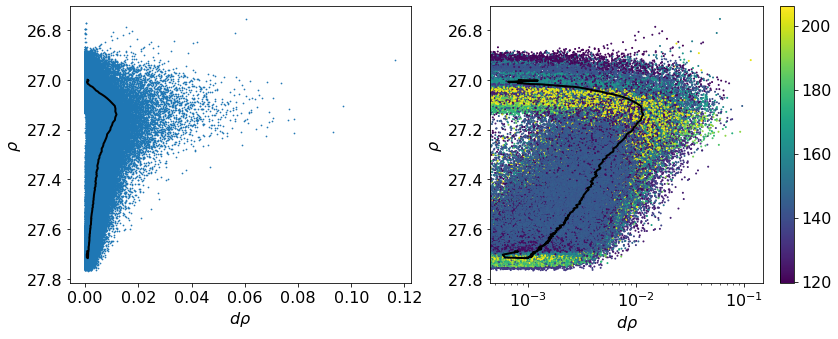

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(ds_660_z.sigma0.diff('ctd_pressure'), ds_660_z.sigma0[1:,:],
           s=0.5)
plt.plot(ds_660_z.sigma0.diff('ctd_pressure').mean('dives'), 
         ds_660_z.sigma0[1:,:].mean('dives'), color='k', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel(r'$d \rho$')
plt.ylabel(r'$\rho$')
#plt.xscale('log')

plt.subplot(122)
plt.scatter(ds_660_z.sigma0.diff('ctd_pressure'), ds_660_z.sigma0[1:,:],
           s=1, c=ds_660_z.days[1:,:])
plt.plot(ds_660_z.sigma0.diff('ctd_pressure').mean('dives'), 
         ds_660_z.sigma0[1:,:].mean('dives'), color='k', linewidth=2)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel(r'$d \rho$')
plt.ylabel(r'$\rho$')

plt.tight_layout()

(array([0.20458534, 0.18647272, 0.86460493, 0.93290916, 1.21703728,
        0.60131724, 0.37109053, 0.41462629, 0.52657539, 0.62935907,
        0.72843293, 0.85838554, 1.0040503 , 1.13258445, 1.33291442,
        1.5459014 , 1.88665874, 2.2964841 , 2.96556   , 3.03135465,
        1.20852653]),
 array([26.88745462, 26.92922671, 26.97099879, 27.01277088, 27.05454297,
        27.09631506, 27.13808714, 27.17985923, 27.22163132, 27.2634034 ,
        27.30517549, 27.34694758, 27.38871967, 27.43049175, 27.47226384,
        27.51403593, 27.55580802, 27.5975801 , 27.63935219, 27.68112428,
        27.72289636, 27.76466845]),
 <BarContainer object of 21 artists>)

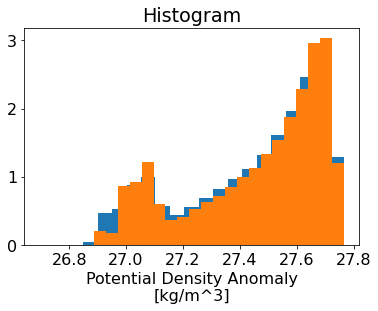

In [7]:
ds_660_z.sigma0.plot.hist(bins=21, density=True)
ds_659_z.sigma0.plot.hist(bins=21, density=True)

In [8]:
rho_grid = np.linspace(26.9, 27.8,901)

#### Pressure to density grid
The interpolation requires us to invert functions like 
\begin{equation}
\rho = f(p)
\end{equation}
to 
\begin{equation}
p = g(\rho)
\end{equation}

and also
$$
T = f(p)
$$
to
$$
T = f(g(\rho))
$$

This can be done using interpolation, where we 
- take the variables as a function of pressure and the associated non-uniformly spaced density.
- Find the interpolant function that relates the variable to the non-uniformly spaced density.
- Use this interpolant function to estimate the values at a set of uniformly spaced density points. 

In [11]:
# Try on a single dive
dive_num = 100

rho = ds_660_grid.sigma0.sel(dives=dive_num)
rho_nonan = rho.where(~np.isnan(rho), drop=True)
pres_nonan = ds_660_grid.ctd_pressure.where(~np.isnan(rho), drop=True)
CT_nonan = ds_660_grid.CT.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
SA_nonan = ds_660_grid.SA.sel(dives=dive_num).where(~np.isnan(rho), drop=True)
O2_nonan = ds_660_grid.Oxygen.sel(dives=dive_num).where(~np.isnan(rho), drop=True)

# Here we find the function p = f(\rho)
frho = interpolate.PchipInterpolator(rho_nonan, pres_nonan, extrapolate=False)#, bounds_error=False )
pres_tilde = frho(rho_grid)

# CT = f(\rho)
fCT = interpolate.PchipInterpolator(rho_nonan, CT_nonan, extrapolate=False)#, bounds_error=False )
CT_tilde = fCT(rho_grid)

# SA = f(\rho)
fSA = interpolate.PchipInterpolator(rho_nonan, SA_nonan, extrapolate=False)#, bounds_error=False )
SA_tilde = fSA(rho_grid)

# O2 = f(\rho)
fO2 = interpolate.PchipInterpolator(rho_nonan, O2_nonan, extrapolate=False)#, bounds_error=False )
O2_tilde = fO2(rho_grid)

(600.0, 900.0)

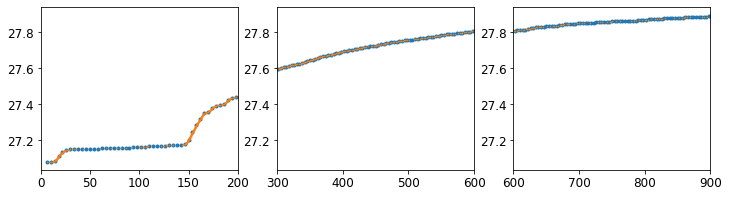

In [10]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([0,200])

plt.subplot(132)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([300,600])

plt.subplot(133)
plt.plot(pres_nonan, rho_nonan, '.')
plt.plot(pres_tilde, rho_grid, '.', markersize=1)
plt.xlim([600,900])


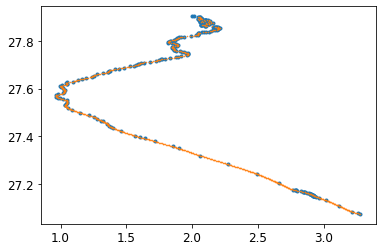

In [66]:
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)

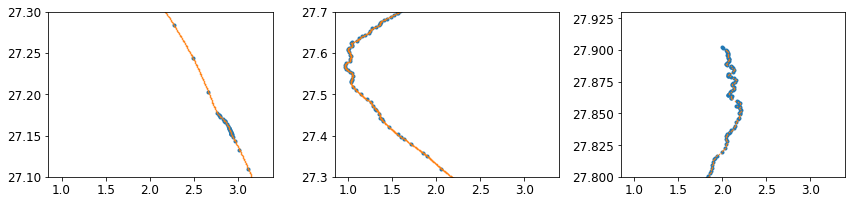

In [67]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(CT_nonan, rho_nonan, '.')
plt.plot(CT_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.80,27.93])

plt.tight_layout()

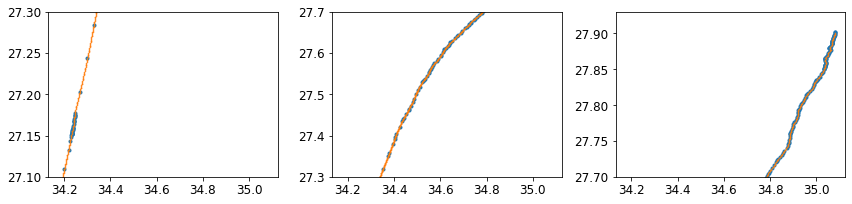

In [68]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(SA_nonan, rho_nonan, '.')
plt.plot(SA_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.7,27.93])

plt.tight_layout()

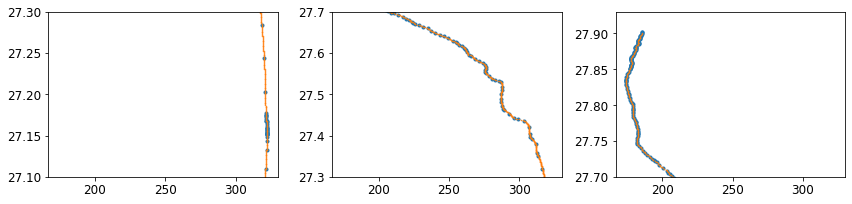

In [12]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.plot(O2_nonan, rho_nonan, '.')
plt.plot(O2_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.1,27.3])

plt.subplot(132)
plt.plot(O2_nonan, rho_nonan, '.')
plt.plot(O2_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.3,27.7])

plt.subplot(133)
plt.plot(O2_nonan, rho_nonan, '.')
plt.plot(O2_tilde, rho_grid, '.', markersize=1)
plt.ylim([27.7,27.93])

plt.tight_layout()

In [69]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 250, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:20.70...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
    days          (ctd_pressure, dives) float64 119.5 119.5 nan ... nan nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-07-26 18:06:26] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [70]:
pres_tilde.reshape((-1,1)).shape

(901, 1)

In [13]:
pres_tilde_xr = xr.DataArray( pres_tilde.reshape((-1,1)), 
            dims=['rho_grid', 'dives'],
            coords={'rho_grid':rho_grid, 'dives': [1.] })

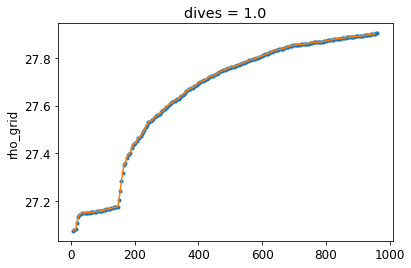

In [14]:
plt.plot(pres_nonan, rho_nonan, '.')
pres_tilde_xr.plot(y='rho_grid')

In [73]:
xr.concat([pres_tilde_xr, pres_tilde_xr], dim='dives')

<xarray.DataArray (rho_grid: 901, dives: 2)>
array([[         nan,          nan],
       [         nan,          nan],
       [         nan,          nan],
       ...,
       [945.26994179, 945.26994179],
       [949.50299837, 949.50299837],
       [953.94529129, 953.94529129]])
Coordinates:
  * rho_grid  (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives     (dives) float64 1.0 1.0

In [74]:
ds_660_grid.isel(dives=0)

<xarray.Dataset>
Dimensions:       (ctd_pressure: 250)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
    dives         float64 1.0
Data variables:
    sigma0        (ctd_pressure) float64 ...
    SA            (ctd_pressure) float64 ...
    CT            (ctd_pressure) float64 ...
    time          (ctd_pressure) datetime64[ns] 2019-04-30T12:15:20.707000064...
    latitude      (ctd_pressure) float64 ...
    longitude     (ctd_pressure) float64 ...
    days          (ctd_pressure) float64 119.5 119.5 119.5 119.5 ... nan nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-07-26 18:06:26] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

### Here is the meat of the calculations

In [19]:
def func_var_int(ds, var, flag='group'):
    
    dive_num = ds['dives'].values
    
    rho = ds.sigma0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(rho), drop=True)
    
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', 'dives'],
                        coords = {'rho_grid': rho_grid, 'dives': [dive_num]}).rename(var)

In [20]:
dive_ind = 0
pres_tilde_xr = func_var_int(ds_660_z.isel(dives=dive_ind), 'ctd_pressure')
CT_tilde_xr   = func_var_int(ds_660_z.isel(dives=dive_ind), 'CT')
SA_tilde_xr   = func_var_int(ds_660_z.isel(dives=dive_ind), 'SA')
O2_tilde_xr   = func_var_int(ds_660_z.isel(dives=dive_ind), 'Oxygen')
lat_tilde_xr  = func_var_int(ds_660_z.isel(dives=dive_ind), 'latitude')
lon_tilde_xr  = func_var_int(ds_660_z.isel(dives=dive_ind), 'longitude')
days_tilde_xr = func_var_int(ds_660_z.isel(dives=dive_ind), 'days')

for dive_ind in range(1, len(ds_660_z.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    pres_tilde_xr = xr.concat([pres_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'ctd_pressure')], dim='dives')
    CT_tilde_xr = xr.concat([CT_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'CT')], dim='dives')
    SA_tilde_xr = xr.concat([SA_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'SA')], dim='dives')
    O2_tilde_xr = xr.concat([O2_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'Oxygen')], dim='dives')
    lat_tilde_xr = xr.concat([lat_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'latitude')], dim='dives')
    lon_tilde_xr = xr.concat([lon_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'longitude')], dim='dives')
    days_tilde_xr = xr.concat([days_tilde_xr , func_var_int(ds_660_z.isel(dives=dive_ind), 'days')], dim='dives')

ds_660_tilde = xr.merge([pres_tilde_xr, CT_tilde_xr,
                         SA_tilde_xr, O2_tilde_xr, lat_tilde_xr,
                         lon_tilde_xr, days_tilde_xr])

100
200
300
400
500
600
700
800
900
1000


In [21]:
dive_ind = 0
pres_tilde_xr = func_var_int(ds_659_z.isel(dives=dive_ind), 'ctd_pressure')
CT_tilde_xr   = func_var_int(ds_659_z.isel(dives=dive_ind), 'CT')
SA_tilde_xr   = func_var_int(ds_659_z.isel(dives=dive_ind), 'SA')
O2_tilde_xr   = func_var_int(ds_659_z.isel(dives=dive_ind), 'Oxygen')
lat_tilde_xr  = func_var_int(ds_659_z.isel(dives=dive_ind), 'latitude')
lon_tilde_xr  = func_var_int(ds_659_z.isel(dives=dive_ind), 'longitude')
days_tilde_xr = func_var_int(ds_659_z.isel(dives=dive_ind), 'days')

for dive_ind in range(1, len(ds_659_z.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    pres_tilde_xr = xr.concat([pres_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'ctd_pressure')], dim='dives')
    CT_tilde_xr   = xr.concat([CT_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'CT')], dim='dives')
    SA_tilde_xr   = xr.concat([SA_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'SA')], dim='dives')
    O2_tilde_xr   = xr.concat([O2_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'Oxygen')], dim='dives')
    lat_tilde_xr  = xr.concat([lat_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'latitude')], dim='dives')
    lon_tilde_xr  = xr.concat([lon_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'longitude')], dim='dives')
    days_tilde_xr = xr.concat([days_tilde_xr , func_var_int(ds_659_z.isel(dives=dive_ind), 'days')], dim='dives')

ds_659_tilde = xr.merge([pres_tilde_xr, CT_tilde_xr,
                         SA_tilde_xr, O2_tilde_xr, lat_tilde_xr,
                         lon_tilde_xr, days_tilde_xr])

100
200
300
400
500
600
700
800
900


In [22]:
ds_660_tilde.to_netcdf('data/sg_O2_660_isopycnal_grid_4m_27_sept_2021.nc')
ds_659_tilde.to_netcdf('data/sg_O2_659_isopycnal_grid_4m_27_sept_2021.nc')

In [36]:
import hvplot.xarray
import panel as pn
pn.extension()

In [42]:
def interactive_profile(var='CT',type_grid='grid', dive_num=95):
    dive_num = float(dive_num)
    
    if type_grid=='grid':
        plot = ds_660_grid.CT.sel(dives = dive_num).hvplot() 
    else:
        plot = ds_660_tilde.CT.sel(dives = dive_num).hvplot()
    
    return plot

In [46]:
discrete_slider = pn.widgets.DiscreteSlider(name='Dive number',
                                           options= list(np.arange(1,510,0.5)),
                                           value=300)

layout_grid = pn.interact(interactive_profile, type_grid='grid', dive_num= discrete_slider)
layout_tilde = pn.interact(interactive_profile, type_grid='tilde', dive_num= discrete_slider)

In [47]:
pn.Column(discrete_slider, layout_grid[1], layout_tilde[1])


Column
    [0] DiscreteSlider(name='Dive number', options=[1.0, 1.5, 2.0, ...], value=300, value_throttled=300)
    [1] Row
        [0] HoloViews(Curve, name='interactive05139')
    [2] Row
        [0] HoloViews(Curve, name='interactive05227')

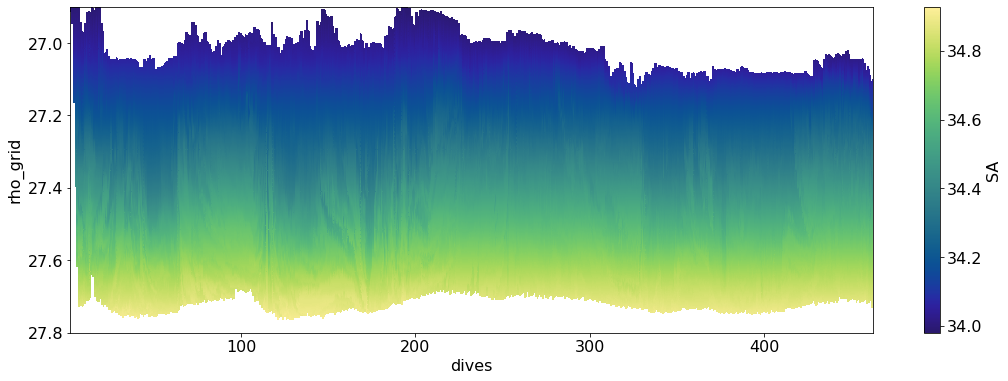

In [23]:
plt.figure(figsize=(18,6))
ds_659_tilde.SA.plot(cmap=cmo.haline)
plt.gca().invert_yaxis()

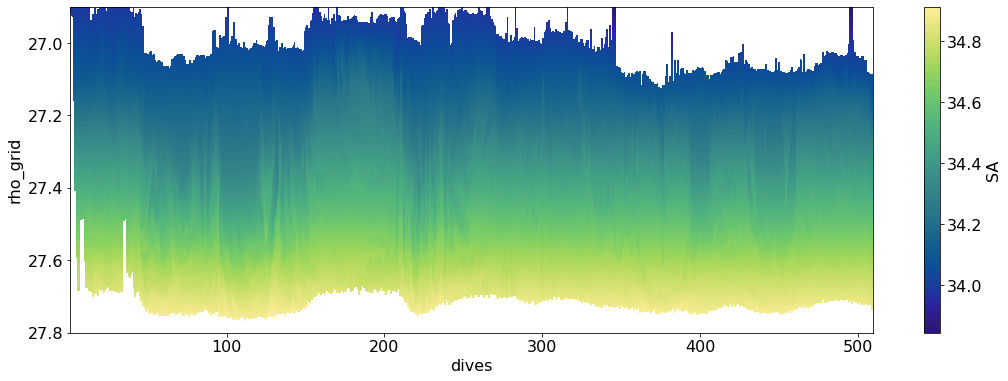

In [24]:
plt.figure(figsize=(18,6))
ds_660_tilde.SA.plot(cmap=cmo.haline)
plt.gca().invert_yaxis()

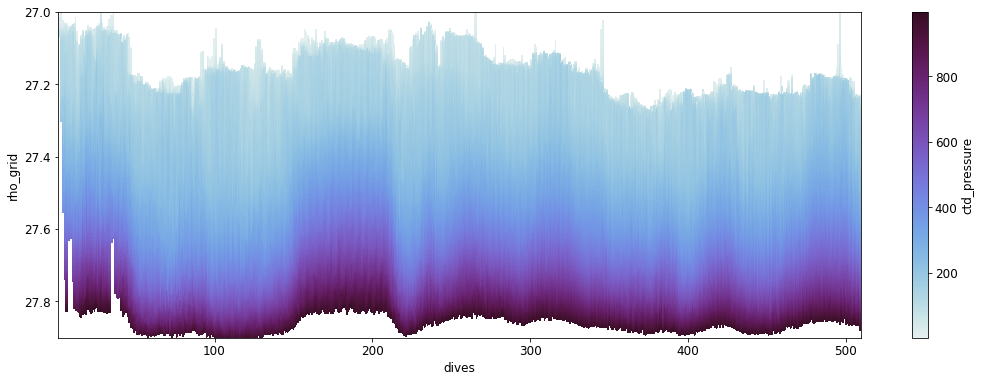

In [17]:
plt.figure(figsize=(18,6))
ds_660_tilde.ctd_pressure.plot(cmap=cmo.dense)
plt.gca().invert_yaxis()

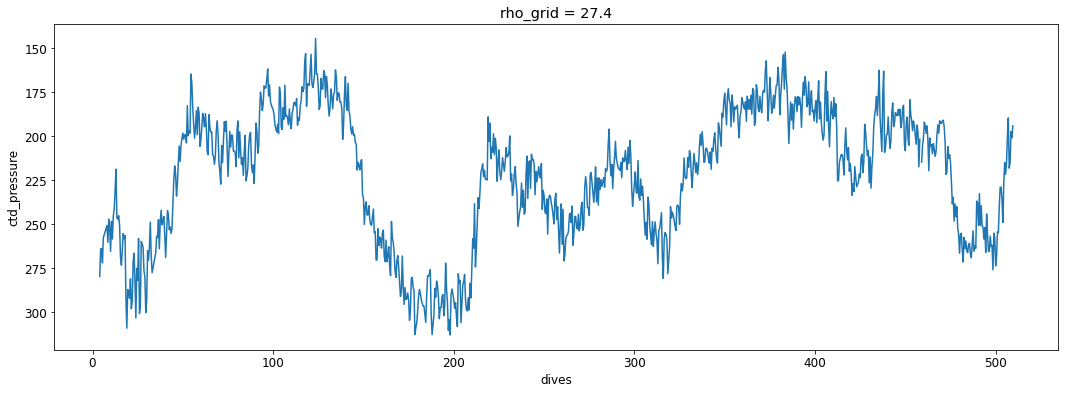

In [99]:
plt.figure(figsize=(18,6))
ds_660_tilde.ctd_pressure.sel(rho_grid=27.4, method='nearest').plot()
plt.gca().invert_yaxis()